In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

# 1. 掩蔽softmax操作

In [3]:
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作（mask掉无效部分）"""
    # X: 3D张量 (batch_size, 查询个数, 键值对个数)
    # valid_lens: 1D或2D张量，表示每个序列有效长度（用于处理padding）
    if valid_lens is None:
        # 如果没有mask，直接对最后一维做softmax
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape  # 记录原始形状
        # 如果valid_lens是一维的，需要扩展成和X每个样本对应的长度
        if valid_lens.dim() == 1:
            # repeat_interleave把每个有效长度扩展到对应的查询个数
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 先把X拉平成2D (batch*query, key)，再mask
        # 超出有效长度的部分全赋为-1e6，softmax后这些地方就是0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        # 再reshape回原始3D，最后一维做softmax
        return nn.functional.softmax(X.reshape(shape), dim=-1)


In [4]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.2881, 0.7119, 0.0000, 0.0000],
         [0.4443, 0.5557, 0.0000, 0.0000]],

        [[0.3089, 0.2612, 0.4299, 0.0000],
         [0.2755, 0.2514, 0.4731, 0.0000]]])

In [5]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3335, 0.2280, 0.4384, 0.0000]],

        [[0.5906, 0.4094, 0.0000, 0.0000],
         [0.2464, 0.2044, 0.2506, 0.2986]]])

# 2. 加性注意力 additive attention

In [7]:
class AdditiveAttention(nn.Module):
    """加性注意力（Additive Attention）"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        # 将key映射到隐藏空间
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        # 将query映射到同样的隐藏空间
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        # attention打分用的参数向量（输出一个标量score）
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        # dropout，防止过拟合
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        # queries: (batch, 查询个数, query_size)
        # keys:    (batch, 键值对个数, key_size)
        # values:  (batch, 键值对个数, value_dim)
        # valid_lens: (batch,) 或 (batch, 查询个数)

        # 线性变换，将query和key都投影到同一隐藏空间
        queries, keys = self.W_q(queries), self.W_k(keys)

        # 扩展维度后，queries变(batch, 查询个数, 1, hidden)
        # keys变(batch, 1, 键值对个数, hidden)
        # 利用广播机制，两者求和后得到(batch, 查询个数, 键值对个数, hidden)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)  # 非线性激活，增强表达能力

        # self.w_v输出一个score，对应每个(query, key)对
        # scores形状：(batch, 查询个数, 键值对个数)
        scores = self.w_v(features).squeeze(-1)

        # 对scores做masked softmax，得到attention权重
        self.attention_weights = masked_softmax(scores, valid_lens)

        # 对values用attention权重加权平均
        # bmm: (batch, 查询个数, 键值对个数) × (batch, 键值对个数, value_dim)
        # 输出：(batch, 查询个数, value_dim)
        return torch.bmm(self.dropout(self.attention_weights), values)


In [8]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

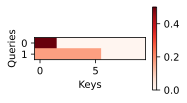

In [9]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

# 3. 缩放点积注意力

In [10]:
class DotProductAttention(nn.Module):
    """缩放点积注意力（Scaled Dot-Product Attention）"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        # dropout防止过拟合
        self.dropout = nn.Dropout(dropout)

    # queries: (batch_size, 查询个数, d)
    # keys: (batch_size, 键-值对个数, d)
    # values: (batch_size, 键-值对个数, value_dim)
    # valid_lens: (batch_size,) 或 (batch_size, 查询个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]  # 最后一个维度就是特征维
        # 1. 计算每个query和所有key的点积（相似度打分）
        # keys.transpose(1,2): (batch, d, 键-值对个数)
        # scores: (batch, 查询个数, 键-值对个数)
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        # 2. 对scores做masked softmax，处理padding
        self.attention_weights = masked_softmax(scores, valid_lens)
        # 3. 用attention权重对values加权平均，得到加权结果
        # (batch, 查询个数, 键-值对个数) × (batch, 键-值对个数, value_dim)
        # --> (batch, 查询个数, value_dim)
        return torch.bmm(self.dropout(self.attention_weights), values)


In [11]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

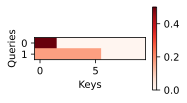

In [12]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')